**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

# Exercise 2: Benefit of BatchNorm with CIFAR10 Classification

In [1]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary
import numpy as np

In [2]:
Transform = ToTensor()

train_data = datasets.CIFAR10(
    root = "../data",
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = "../data", 
    train = False, 
    transform = Transform,
    download = True
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

n_classes = len(train_data.classes)
input_size = (train_loader.batch_size, *train_data[0][0].shape)

In [4]:
def train(epoch, model, optimizer, criterion, data_loader, log_interval=200):
    
    model.train()
    
    total_train_loss = 0
    total_correct = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)

        loss.backward()
        
        optimizer.step()
        
        total_train_loss += loss.item()
        
        pred = output.argmax(dim=1)
        
        total_correct += torch.sum(pred == target).item()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{:5}/{:5} ({:2.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

    accuracy_train = total_correct / len(data_loader.dataset)

    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [5]:
@torch.inference_mode()
def validate(model, data_loader):
   
    model.eval()
    
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        output = model(data)
        val_loss += criterion(output, target).item()
        
        pred = output.argmax(dim=1)
        total_correct += torch.sum(pred == target).item()
        total_preds.append(pred.detach().cpu())
        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print("Validation set: Average loss: {:.4f}, Accuracy: {:5}/{:5} ({:2.2f}%)\n".format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

In [ ]:
def train_eval_loop(optimizer, criterion, epochs=7):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        train_result = train(epoch, model, optimizer, criterion, train_loader)
        train_losses.append(train_result["loss"])
        train_accuracies.append(train_result["accuracy"])

        val_result = validate(model, test_loader)
        val_losses.append(val_result["loss"])
        val_accuracies.append(val_result["accuracy"])
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
def plot_performance(train_losses, train_accuracies, val_losses, val_accuracies):
    f = plt.figure(figsize=(12,6))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    ax1.plot(train_losses, label="Training loss")
    ax1.plot(val_losses, label="Testing loss")
    plt.xlabel("epoch")
    ax1.legend()
    ax1.grid()

    ax2.plot(train_accuracies, label="Training acc")
    ax2.plot(val_accuracies, label="Test acc")
    plt.xlabel("epoch")
    ax2.legend()
    ax2.grid()

In [ ]:
def get_model(activation_function, batchnorm=False, dropout=False):
    model = nn.Sequential(
        nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            padding="same",
            stride=1,
        ),
        nn.BatchNorm2d(32) if batchnorm else nn.Identity(),
        activation_function(),
        nn.MaxPool2d(2),
        nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding="same",
            stride=1,
        ),
        nn.BatchNorm2d(64) if batchnorm else nn.Identity(),
        activation_function(),
        nn.MaxPool2d(2),
        nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            padding="same",
            stride=1,
        ),
        nn.BatchNorm2d(128) if batchnorm else nn.Identity(),
        activation_function(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Dropout(.2) if dropout else nn.Identity(),
        nn.Linear(32*32 * 128 // 4 // 4 // 4, 64),
        nn.BatchNorm1d(64) if batchnorm else nn.Identity(),
        activation_function(),
        nn.Dropout(.2) if dropout else nn.Identity(),
        nn.Linear(64, n_classes),
        #nn.BatchNorm1d(n_classes) if batchnorm else nn.Identity(), #??
        # nn.Softmax(dim=0) # not needed when crossentropyloss is used
    )
    return model, optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

## a) base

In [9]:
model, optimizer = get_model(activation_function=nn.ReLU)
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [128, 32, 32, 32]         896
├─Identity: 1-2                          [128, 32, 32, 32]         --
├─ReLU: 1-3                              [128, 32, 32, 32]         --
├─MaxPool2d: 1-4                         [128, 32, 16, 16]         --
├─Conv2d: 1-5                            [128, 64, 16, 16]         18,496
├─Identity: 1-6                          [128, 64, 16, 16]         --
├─ReLU: 1-7                              [128, 64, 16, 16]         --
├─MaxPool2d: 1-8                         [128, 64, 8, 8]           --
├─Conv2d: 1-9                            [128, 128, 8, 8]          73,856
├─Identity: 1-10                         [128, 128, 8, 8]          --
├─ReLU: 1-11                             [128, 128, 8, 8]          --
├─MaxPool2d: 1-12                        [128, 128, 4, 4]          --
├─Flat

## b) relu

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.306485
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.623779


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.4310, Accuracy:  4842/10000 (48.42%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 1.428466
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.230399


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.2509, Accuracy:  5493/10000 (54.93%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 1.172634
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.221417


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.1247, Accuracy:  5935/10000 (59.35%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 1.172230
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.002753


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0406, Accuracy:  6300/10000 (63.00%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 0.984220
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.897124


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9504, Accuracy:  6667/10000 (66.67%)



Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 6 [    0/50000 ( 0%)]	Loss: 0.950526
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.944699


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8972, Accuracy:  6837/10000 (68.37%)



Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 7 [    0/50000 ( 0%)]	Loss: 0.751781
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.820461


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8772, Accuracy:  6942/10000 (69.42%)



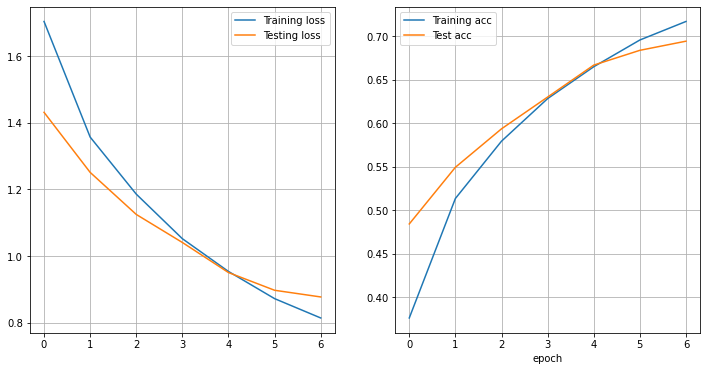

In [10]:
results_b = train_eval_loop(optimizer, criterion)
plot_performance(*results_b)

## c) tanh

In [11]:
model, optimizer = get_model(activation_function=nn.Tanh)
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [128, 32, 32, 32]         896
├─Identity: 1-2                          [128, 32, 32, 32]         --
├─Tanh: 1-3                              [128, 32, 32, 32]         --
├─MaxPool2d: 1-4                         [128, 32, 16, 16]         --
├─Conv2d: 1-5                            [128, 64, 16, 16]         18,496
├─Identity: 1-6                          [128, 64, 16, 16]         --
├─Tanh: 1-7                              [128, 64, 16, 16]         --
├─MaxPool2d: 1-8                         [128, 64, 8, 8]           --
├─Conv2d: 1-9                            [128, 128, 8, 8]          73,856
├─Identity: 1-10                         [128, 128, 8, 8]          --
├─Tanh: 1-11                             [128, 128, 8, 8]          --
├─MaxPool2d: 1-12                        [128, 128, 4, 4]          --
├─Flat

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.304910
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.335939


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.1907, Accuracy:  5790/10000 (57.90%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 1.065759
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.148102


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0128, Accuracy:  6366/10000 (63.66%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 0.883469
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.108487


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9668, Accuracy:  6578/10000 (65.78%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 0.830630
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.880629


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8771, Accuracy:  6994/10000 (69.94%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 0.717149
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.751756


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8671, Accuracy:  7054/10000 (70.54%)



Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 6 [    0/50000 ( 0%)]	Loss: 0.545409
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.638160


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8153, Accuracy:  7228/10000 (72.28%)



Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 7 [    0/50000 ( 0%)]	Loss: 0.464356
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.486970


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.8329, Accuracy:  7196/10000 (71.96%)



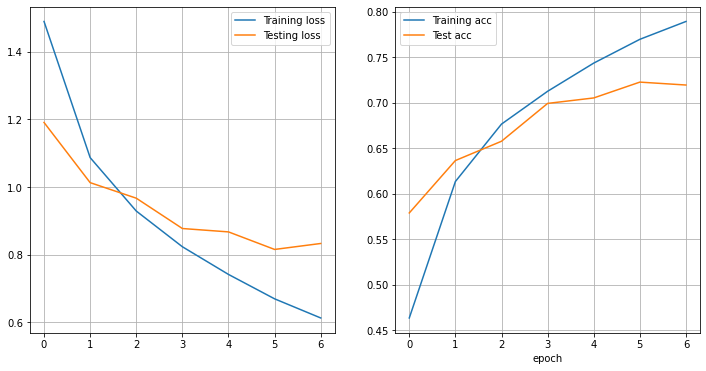

In [12]:
results_c = train_eval_loop(optimizer, criterion)
plot_performance(*results_c)

## d) batchnorm

In [ ]:
model, optimizer = get_model(activation_function=nn.ReLU, batchnorm=True)
summary(model, input_size=input_size)

In [ ]:
results_d_relu = train_eval_loop(optimizer, criterion)
plot_performance(*results_d_relu)

In [ ]:
model, optimizer = get_model(activation_function=nn.Tanh, batchnorm=True)
summary(model, input_size=input_size)

In [ ]:
results_d_tanh = train_eval_loop(optimizer, criterion)
plot_performance(*results_d_tanh)

## e) dropout

In [ ]:
model, optimizer = get_model(activation_function=nn.Tanh, dropout=True, batchnorm=False)
summary(model, input_size=input_size)

In [ ]:
results_d_tanh = train_eval_loop(optimizer, criterion)
plot_performance(*results_d_tanh)

In [ ]:
model, optimizer = get_model(activation_function=nn.Tanh, dropout=True, batchnorm=True)
summary(model, input_size=input_size)

In [ ]:
results_d_tanh = train_eval_loop(optimizer, criterion)
plot_performance(*results_d_tanh)

## f) comparison